<a href="https://colab.research.google.com/github/alonziv1/Data-Processing-and-Representation-/blob/main/Image%20Compression%20with%20Lp%20Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import libraries

In [ ]:
#@title 
import numpy as np
import pandas as pd
from skimage import io
from skimage.color import rgb2gray
import matplotlib.pylab as plt
from math import exp
from PIL import Image 

##**Import Image**

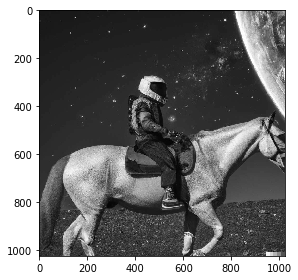

In [ ]:
image = io.imread('https://cdn.openai.com/dall-e-2/demos/text2im/astronaut/horse/photo/5.jpg',as_gray=True) 
io.imshow(image)

**quantizer class**

In [ ]:
#@title 
class quantizer:
  def __init__(self, quantization_values):
    self.quantization_values = quantization_values

  def quntize(self, value):
    return self.quantization_values[(np.abs(self.quantization_values - value)).argmin()]

**Quantize the image to 256 gray scale levels**

In [ ]:
#@title 
uniform_quantization_values = np.arange(0,1+1/255,1/255)
uniform_quantizer = quantizer(uniform_quantization_values)

vec_uniform_quantizer = np.vectorize(uniform_quantizer.quntize)
quantized_image = vec_uniform_quantizer(image)
# io.imshow(quantized_image)

#**Lp Solver**

**compressed_image class implementation**

In [ ]:
#@title 
class compressed_image:
  def __init__(self, original_image, sampling_size,epsilon =  1, P =  3 , start_value = 0.5):
    self.original_image = original_image
    self.original_size = original_image.shape[0]
    self.sampling_size = sampling_size
    self.block_size = int(self.original_size / sampling_size)
    self.epsilon = epsilon
    self.P = P
    self.compressed_image = np.full_like(a = original_image ,fill_value = start_value)
    self.weights = np.full_like(a = original_image ,fill_value = start_value)
    self.updateWeights()

  def improveCompressedImage(self):
      for row in range(self.sampling_size):
        for col in range(self.sampling_size):
          quantized_value = self.calculateValue(row, col)
          self.setCell(row,col,quantized_value)

      self.updateWeights()
      return 


  def calculateValue(self, x, y):
    product_sum = 0
    weights_sum = 0 
    rows = np.arange(x*self.block_size, (x+1)*self.block_size)
    cols = np.arange(y*self.block_size, (y+1)*self.block_size)
    for row in rows:
      for col in cols:
        product_sum += self.weights[row][col] * self.original_image[row][col]
        weights_sum += self.weights[row][col]
    value = product_sum / weights_sum
    return value

  def calculateMedianValue(self, x, y):
    values = []
    rows = np.arange(x*self.block_size, (x+1)*self.block_size)
    cols = np.arange(y*self.block_size, (y+1)*self.block_size)
    for row in rows:
      for col in cols:
        values.append(self.original_image[row][col])
    median = np.median(values)
    return median     

  def setCell(self, x,y,value):
    rows = np.arange(x*self.block_size, (x+1)*self.block_size)
    cols = np.arange(y*self.block_size, (y+1)*self.block_size)
    for row in rows:
      for col in cols:
         self.compressed_image[row][col] = value
  
  def get_weight(self, x, y , numeric_error = 10**(-6)):
    diff = abs(self.compressed_image[x][y]- self.original_image[x][y])
    if (diff < numeric_error):
      weight = numeric_error
    else:
      weight = min(abs(diff)**(self.P - 2), 1/self.epsilon)
    return weight


  def NormalizeData(self, data):
    return data * np.max(data)**(-1)

  def updateWeights(self):
    for row in range(self.original_size):
        for col in range(self.original_size):
          self.weights[row][col] = self.get_weight(row, col) 

    self.weights = self.weights * np.max(self.weights)**(-1)

  def getMeanPError(self):
    error_image = abs(self.compressed_image - self.original_image)
    mse = (np.sum(error_image** self.P)) / (self.original_size**(2))
    return mse 

  def getCompressedImage(self):
    return self.compressed_image


**Lp_solver class implementation**

In [ ]:
#@title
class Lp_solver:
  def __init__(self,P =3 , delta = 10**(-4)):
    self.P = P
    self.delta = delta
    
  def compress(self, original_image, sampling_size = 64, epsilon =  1, max_iterations = 6):
    #init 
    current_compressed_image = compressed_image(original_image,sampling_size, epsilon, self.P)
    last_error = current_compressed_image.getMeanPError()
    improvement = last_error
    iteration =0
    data = [last_error]

    #iterations
    while (improvement > self.delta and iteration < max_iterations):
      
      current_compressed_image.improveCompressedImage()
    
      current_error = current_compressed_image.getMeanPError()
      improvement = abs(last_error - current_error)
      data.append(current_error)
      last_error = current_error
      iteration+=1

    return current_compressed_image.getCompressedImage() , current_compressed_image.getMeanPError()
  


#**L1 Optimal Solver**

**L1_optimal_solver class implementation**

In [ ]:
#@title
class L1_optimal_solver:
  
  def compress(self, original_image, sampling_size = 64):
    L1_compressed_image = compressed_image(original_image,sampling_size)
    for row in range(sampling_size):
        for col in range(sampling_size):
          median_value = L1_compressed_image.calculateMedianValue(row, col)
          L1_compressed_image.setCell(row,col,median_value)
    return L1_compressed_image.compressed_image , L1_compressed_image.getMeanPError()

    



#**comparison - approx L1 and optimal L1**

##**samplimg sizes**

In [ ]:
sampling_sizes = [2,4,8,16,32,64,128,256,512]

**compress the image with diffrent sampling sizes**

In [ ]:
#@title
#optimal
optimal_L1_MAD = []
optimal_L1_compressed_images = []
optimal_L1_solver = L1_optimal_solver()
for sampling_size in sampling_sizes:
  optimal_L1_compressed_image , MAD = optimal_L1_solver.compress(quantized_image,sampling_size )
  optimal_L1_MAD.append(MAD)
  optimal_L1_compressed_images.append(optimal_L1_compressed_image)

#approx
approx_L1_MAD = []
approx_L1_compressed_images = []
for sampling_size in sampling_sizes:
  approx_L1_solver = Lp_solver(1)
  approx_L1_compressed_image , MAD = approx_L1_solver.compress(quantized_image,sampling_size)
  approx_L1_MAD.append(MAD)
  approx_L1_compressed_images.append(approx_L1_compressed_image)



**choose sampling size between 0 to 8 and see the changes**

In [ ]:
sampling_size = 6

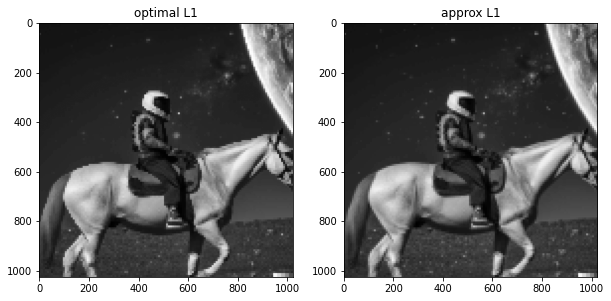

In [ ]:
#@title

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1, title = "optimal L1")
plt.imshow(optimal_L1_compressed_images[sampling_size],  cmap="gray")
fig.add_subplot(1, 2, 2, title = "approx L1")
plt.imshow(approx_L1_compressed_images[sampling_size], cmap="gray")


**see the diffrence of sampling sizes on the squred error**

In [ ]:
#scale the graph with the relevant sampling
start = 0
end = 9

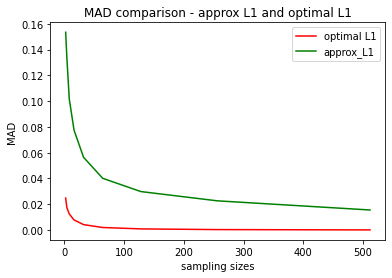

In [ ]:
#@title
# Plotting both the curves simultaneously
plt.plot(sampling_sizes[start:end], optimal_L1_MAD[start:end], color='r', label='optimal L1')
plt.plot(sampling_sizes[start:end], approx_L1_MAD[start:end], color='g', label='approx_L1')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("sampling sizes")
plt.ylabel("MAD")
plt.title("MAD comparison - approx L1 and optimal L1")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()


##**epsilon sizes**

In [ ]:
#@title
#epsilon = 1
approx_L1_MAD1 = []
approx_L1_compressed_images1 = []
for sampling_size in sampling_sizes:
  approx_L1_solver = Lp_solver(1)
  approx_L1_compressed_image , MAD = approx_L1_solver.compress(quantized_image,sampling_size, epsilon = 1)
  approx_L1_MAD1.append(MAD)
  approx_L1_compressed_images1.append(approx_L1_compressed_image)


#epsilon = 0.1
approx_L1_MAD2 = []
approx_L1_compressed_images2 = []
for sampling_size in sampling_sizes:
  approx_L1_solver = Lp_solver(1)
  approx_L1_compressed_image , MAD = approx_L1_solver.compress(quantized_image,sampling_size, epsilon = 0.1)
  approx_L1_MAD2.append(MAD)
  approx_L1_compressed_images2.append(approx_L1_compressed_image)

#epsilon = 0.01
approx_L1_MAD3 = []
approx_L1_compressed_images3 = []
for sampling_size in sampling_sizes:
  approx_L1_solver = Lp_solver(1)
  approx_L1_compressed_image , MAD = approx_L1_solver.compress(quantized_image,sampling_size, epsilon = 0.01)
  approx_L1_MAD3.append(MAD)
  approx_L1_compressed_images3.append(approx_L1_compressed_image)



In [ ]:
#scale the graph with the relevant sampling
start = 6
end = 9

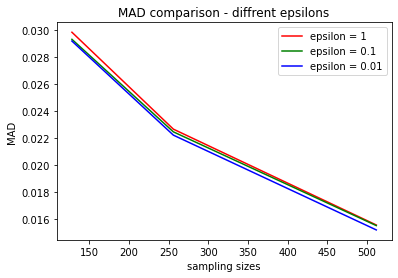

In [ ]:
#@title
# Plotting both the curves simultaneously
plt.plot(sampling_sizes[start:end], approx_L1_MAD1[start:end], color='r', label='epsilon = 1')
plt.plot(sampling_sizes[start:end], approx_L1_MAD2[start:end], color='g', label='epsilon = 0.1')
plt.plot(sampling_sizes[start:end], approx_L1_MAD3[start:end], color='b', label='epsilon = 0.01')


# Naming the x-axis, y-axis and the whole graph
plt.xlabel("sampling sizes")
plt.ylabel("MAD")
plt.title("MAD comparison - diffrent epsilons")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()


#**comparison - approx L 3/2 and  L 4**

In [ ]:
#@title
# L 3/2
approx_L_3_2_errors = []
approx_L_3_2_compressed_images = []
for sampling_size in sampling_sizes:
  approx_L_3_2_solver = Lp_solver(3/2)
  approx_L_3_2_compressed_image , error = approx_L_3_2_solver.compress(quantized_image,sampling_size)
  approx_L_3_2_errors.append(error)
  approx_L_3_2_compressed_images.append(approx_L_3_2_compressed_image)

# L 4 
approx_L4_errors = []
approx_L4_compressed_images = []
for sampling_size in sampling_sizes:
  approx_L4_solver = Lp_solver(4)
  approx_L4_compressed_image , squred_error = approx_L4_solver.compress(quantized_image,sampling_size)
  approx_L4_errors.append(squred_error)
  approx_L4_compressed_images.append(approx_L4_compressed_image)


In [ ]:
#scale the graph with the relevant sampling
start = 0
end = 9

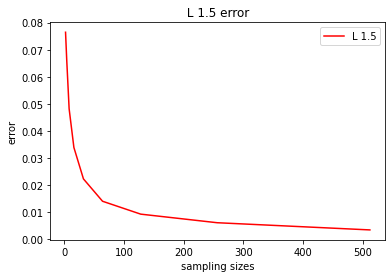

In [ ]:
#@title
# Plotting both the curves simultaneously
plt.plot(sampling_sizes[start:end], approx_L_3_2_errors[start:end], color='r', label='L 1.5')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("sampling sizes")
plt.ylabel("error")
plt.title(" L 1.5 error ")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()


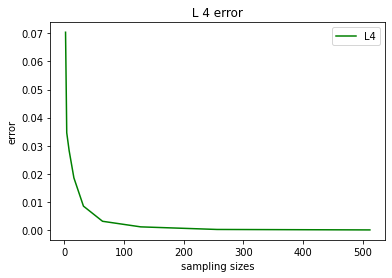

In [ ]:
#@title
# Plotting both the curves simultaneously
plt.plot(sampling_sizes[start:end], approx_L4_errors[start:end], color='g', label='L4')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("sampling sizes")
plt.ylabel("error")
plt.title(" L 4 error ")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()


In [ ]:
sampling_size = 7

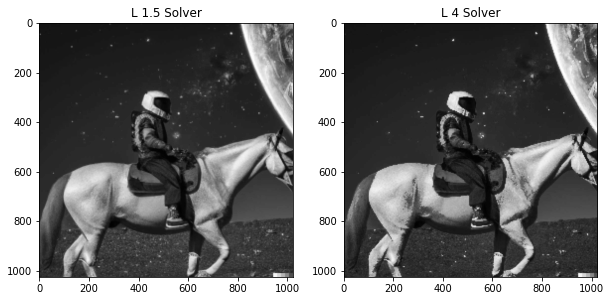

In [ ]:
#@title

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1, title = "L 1.5 Solver")
plt.imshow(approx_L_3_2_compressed_images[sampling_size],  cmap="gray")
fig.add_subplot(1, 2, 2, title = "L 4 Solver")
plt.imshow(approx_L4_compressed_images[sampling_size], cmap="gray")
